In [1]:
# import necessary modules
import numpy as np
import pandas as pd
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.animation as animation
from scipy import stats
from scipy.special import erfc
from scipy.signal import gaussian
from scipy.ndimage import convolve1d
import peakutils
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import random
from random import shuffle
import pickle
import copy
from src.codonTable import codonTable
from src.codonUtils import utils
from src.thunderflask import thunderflask
from src.bacteria import strain
from src.codonOptimizer import tableOptimizer

In [4]:
path = '/home/jonathan/Lab/ATD/codon-tables/data/local_test/N=1e6_b=1_l=2/SC_vs_FF20_0/output/'
with open(path+'2018-04-03_SC_vs_FF20_sim=0_batch=0_favg_traces_N_pop=1e6=T=1000_N=3_b=1_l=2.pickle', 'rb') as handle:
    df = pickle.load(handle)

/usr/local/lib/python3.5/dist-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


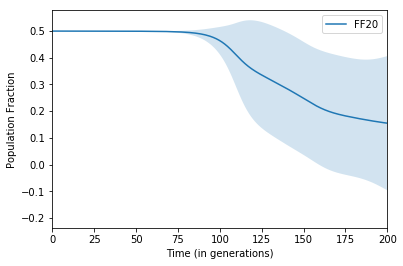

In [38]:
sns.tsplot(data=df, time='time', value='popfrac', unit='sim', condition='code', ci='sd')
plt.xlabel('Time (in generations)')
plt.ylabel('Population Fraction')
plt.xlim([0,200])
plt.legend()
plt.savefig('test_competition.png')
plt.show()

In [7]:
# unpack some dataframes

DF = pd.DataFrame()
filenames = [
#     '/home/jonathan/Lab/ATD/codon-tables/data/competition_test/N=1e6_b=1_l=2/SC_vs_FF16_0/output/2018-04-04_SC_vs_FF16_0_concatenated.pickle', #vs ff16
    '/home/jonathan/Lab/ATD/codon-tables/data/competition_test/N=1e6_b=1_l=2/SC_vs_FF20_0/output/2018-04-04_SC_vs_FF20_0_concatenated.pickle', # vs ff20
    '/home/jonathan/Lab/ATD/codon-tables/data/competition_test/N=1e6_b=1_l=2/SC_vs_Colorado_0/output/2018-04-04_SC_vs_Colorado_0_concatenated.pickle', # vs colorado
    '/home/jonathan/Lab/ATD/codon-tables/data/competition_test/N=1e6_b=1_l=2/SC_vs_RED20_0/output/2018-04-04_SC_vs_RED20_0_concatenated.pickle', # vs red20
    '/home/jonathan/Lab/ATD/codon-tables/data/competition_test/N=1e6_b=1_l=2/SC_vs_PROMISC20_0/output/2018-04-04_SC_vs_PROMISC20_0_concatenated.pickle'
]
# get dataframes
for file in tqdm(filenames, desc='Parsing Dataframes: '):
    with open(file, 'rb') as handle:
        df = pickle.load(handle)
        df = df.loc[(df['sim'] < 10) & (df['code'] != 'Standard Code')]
        DF = pd.concat([DF, df], copy=False)
# with open(filenames[0], 'rb') as handle:
#     df = pickle.load(handle)

HBox(children=(IntProgress(value=0, description='Parsing Dataframes: : ', max=4), HTML(value='')))

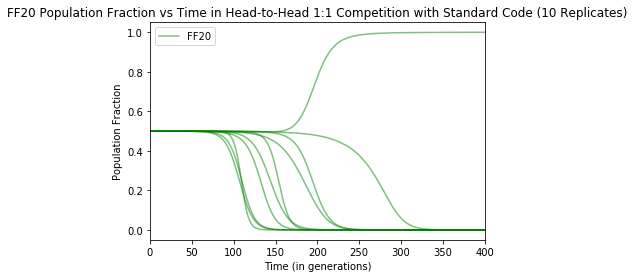

In [39]:
colordict = {
#     'Standard Code' : 'blue',
    'Colorado' : 'red',
    'FF20' : 'green',
    'RED20' : 'purple',
    'PROMISC20' : 'orange'
}
def tracer(code):
    df = DF.loc[DF['code'] == code]
    sims = set(df['sim'])
    for sim in sims:
        lildf = df.loc[df['sim'] == sim]
        t = lildf['time']
        x = lildf['popfrac']
        label = code if sim == 0 else ''
        plt.plot(t, x, color=colordict[code], alpha=0.5, label=label)
tracer('FF20')
plt.xlim([0,400])
plt.title('FF20 Population Fraction vs Time in Head-to-Head 1:1 Competition with Standard Code (10 Replicates)')
plt.xlabel('Time (in generations)')
plt.ylabel('Population Fraction')
plt.legend()
plt.savefig('test_competition_3.png')
plt.show()

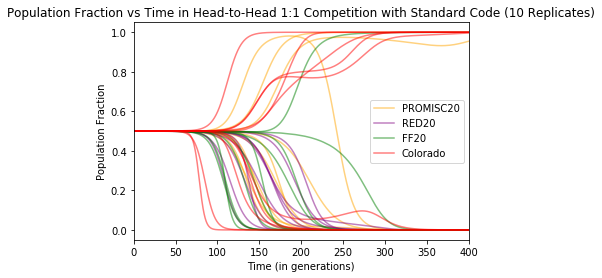

In [37]:
for code in colordict.keys():
    tracer(code)
plt.xlim([0,400])
plt.title('Population Fraction vs Time in Head-to-Head 1:1 Competition with Standard Code (10 Replicates)')
plt.xlabel('Time (in generations)')
plt.ylabel('Population Fraction')
plt.legend()
plt.show()

/usr/local/lib/python3.5/dist-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


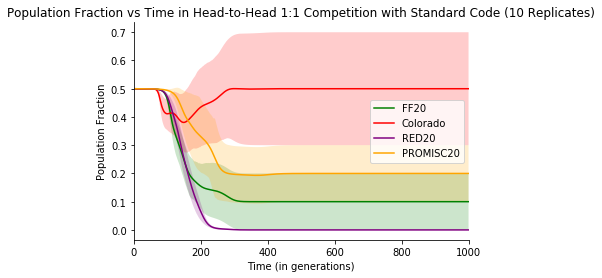

In [9]:
ax1 = sns.tsplot(
    data=DF,
    time='time',
    value='popfrac',
    unit='sim',
    condition='code',
    color=colordict,
    #ci='sd'
)
# format plot
sns.despine()
# plt.xlim([0, 1000])
# plt.ylim([0, 1.3])
plt.legend()
plt.title('Population Fraction vs Time in Head-to-Head 1:1 Competition with Standard Code (10 Replicates)')
plt.xlabel('Time (in generations)')
plt.ylabel('Population Fraction')
plt.savefig('test_competition_2.png')
plt.show()

HBox(children=(IntProgress(value=0, description='Processing sims: : ', max=10001), HTML(value='')))

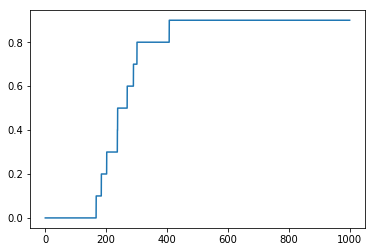

In [54]:
# lets make one contour line
t = df.loc[df['sim'] == 0]['time']
contain_probability = np.zeros(len(t))
num_sims = len(df.loc[df])
for ind in tqdm(range(len(contain_probability)), desc='Processing sims: '):
    lildf = df.loc[ind]
    contain_probability[ind] = sum(lildf['popfrac'] == 0) / num_sims
plt.plot(t, contain_probability)

In [4]:
# lets contour
with open('/home/jonathan/Lab/ATD/codon-tables/data/contour_test/N=1e6_b=1_l=2/SC_vs_FF20_contour_3/output/2018-04-05_SC_vs_FF20_contour_3_concatenated.pickle', 'rb') as handle:
    df = pickle.load(handle)

In [8]:
# get index of N_0 closest to 1:1
ind = np.argmin(np.abs(1 - 2*df['N_0']/(1e6)).values)
df['N_0'].iloc[ind]

398107.17055349774

No handles with labels found to put in legend.


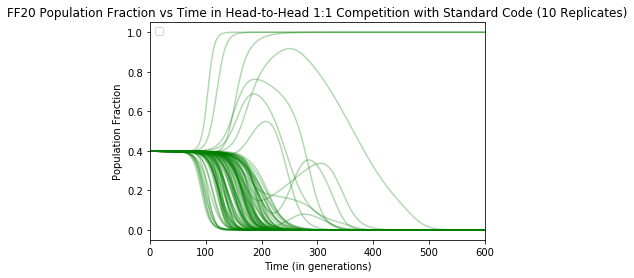

In [16]:
colordict = {
#     'Standard Code' : 'blue',
    'Colorado' : 'red',
    'FF20' : 'green',
    'RED20' : 'purple',
    'PROMISC20' : 'orange'
}
def tracer(DF, code):
    df = DF.loc[DF['code'] == code]
    sims = set(df['sim'])
    colordict = {
#     'Standard Code' : 'blue',
    'Colorado' : 'red',
    'FF20' : 'green',
    'RED20' : 'purple',
    'PROMISC20' : 'orange'
    }
    for sim in sims:
        lildf = df.loc[df['sim'] == sim]
        t = lildf['time']
        x = lildf['popfrac']
        label = code if sim == 0 else ''
        plt.plot(t, x, color=colordict[code], alpha=0.3, label=label)
# get index of N_0 closest to 1:1
ind = np.argmin(np.abs(1 - 2*df['N_0']/(1e6)).values)
n_0 = df['N_0'].iloc[ind]

DF = df.loc[df['N_0']==n_0]
tracer(DF, 'FF20')
plt.xlim([0,600])
plt.title('FF20 Population Fraction vs Time in Head-to-Head 1:1 Competition with Standard Code (10 Replicates)')
plt.xlabel('Time (in generations)')
plt.ylabel('Population Fraction')
plt.legend()
plt.savefig('test_competition_3.png')
plt.show()

In [13]:
DF.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
             991,  992,  993,  994,  995,  996,  997,  998,  999, 1000],
           dtype='int64', length=100100)

In [4]:
# generate probabilities
num_sims = len(df.loc[df['N_0'] == 1e4].loc[69])
t = df.loc[df['sim'] == 0]['time']
N_0 = list(set(df['N_0']))
N_0.sort()
contain_probability = np.zeros((len(N_0), len(t)))
for i, n_0 in enumerate(tqdm(N_0, desc='Processing Initial Conditions: ', leave=False)):
    for j in tqdm(range(len(t)), desc='Processing sims: '):
        lildf = df.loc[df['N_0'] == n_0].loc[j]
        contain_probability[i, j] = sum(lildf['popfrac'] == 0) / num_sims

HBox(children=(IntProgress(value=0, description='Processing Initial Conditions: : ', max=31), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Processing sims: : ', max=1001), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Processing sims: : ', max=1001), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Processing sims: : ', max=1001), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Processing sims: : ', max=1001), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Processing sims: : ', max=1001), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Processing sims: : ', max=1001), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Processing sims: : ', max=1001), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Processing sims: : ', max=1001), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Processing sims: : ', max=1001), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Processing sims: : ', max=1001), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Processing sims: : ', max=1001), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Processing sims: : ', max=1001), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Processing sims: : ', max=1001), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Processing sims: : ', max=1001), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Processing sims: : ', max=1001), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Processing sims: : ', max=1001), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Processing sims: : ', max=1001), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Processing sims: : ', max=1001), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Processing sims: : ', max=1001), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Processing sims: : ', max=1001), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Processing sims: : ', max=1001), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Processing sims: : ', max=1001), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Processing sims: : ', max=1001), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Processing sims: : ', max=1001), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Processing sims: : ', max=1001), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Processing sims: : ', max=1001), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Processing sims: : ', max=1001), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Processing sims: : ', max=1001), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Processing sims: : ', max=1001), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Processing sims: : ', max=1001), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Processing sims: : ', max=1001), HTML(value='')))

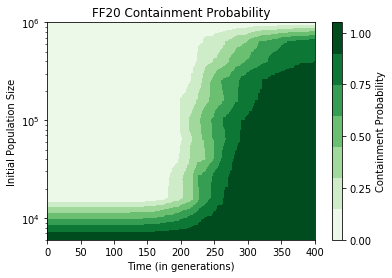

In [17]:
X, Y = np.meshgrid(t, N_0)
CS = plt.contourf(X, Y, contain_probability, cmap=plt.cm.Greens, vmin=0, vmax=1)
#plt.clabel(CS, inline=1, fontsize=10)
ax = plt.gca()
plt.xlim([0,400])
plt.ylim([6e3, 1e6])
# ax.set_xscale("log")
ax.set_yscale("log")

cbar = plt.colorbar(CS, ticks=[0, 0.25, 0.5, 0.75, 1])
cbar.ax.set_ylabel('Containment Probability')
plt.clim(0,1)
# Add the contour line levels to the colorbar
plt.title('FF20 Containment Probability')
plt.xlabel('Time (in generations)')
plt.ylabel('Initial Population Size')
plt.savefig('contour_log_inset.svg')
plt.show()

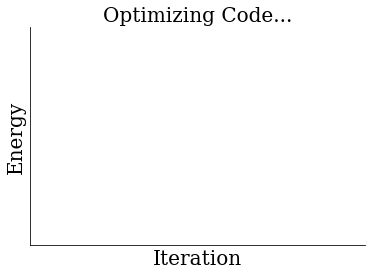

In [4]:
# code optimization video
sim = tableOptimizer()
optimizedTable, Ws, Es = sim.GDA()

# set plot characteristics
labelsize=20
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=labelsize)
plt.rc('ytick', labelsize=labelsize)
plt.rc('axes', labelsize=labelsize)

# set video characteristics
fps = 30
vid_length = 5 # in sec
tot_frames = fps*vid_length

def framer(nFrame):
    plt.cla()
    # adjust frame number to index
    ind = int(nFrame * (len(Es) / tot_frames))
    # plot energy up to that point
    plt.plot(-Es[:ind], '-k')
    plt.xlim([0, len(Es)])
    plt.ylim([min(-Es), max(-Es)])
#     ax.yaxis.grid(False)
    sns.despine()
    ax = plt.gca()
    plt.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,
        labelbottom=False,
        labelleft=False
    )
    plt.xlabel('Iteration')
    plt.ylabel('Energy')
    plt.title('Optimizing Code...', fontsize=labelsize)

framer(0)
fig = plt.gcf()
anim = animation.FuncAnimation(fig, framer, frames=tot_frames)
anim.save('test.gif', writer='imagemagick', fps=fps, dpi=300);

In [4]:
# simulation video 

# control aesthetics
labelsize=20
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=labelsize)
plt.rc('ytick', labelsize=labelsize)
plt.rc('axes', labelsize=labelsize)

# populate sim
LUCA = strain(N_pop=1e6, fitness=0, mu=2e-5)
sim = thunderflask(LUCA)
# initialize some variables
T_curr = 0
mut_param = [1, 2]
dt = 0.1
T_sim = 500

# run simulation
sim.simulate(T_sim, dt, T_curr, mut_param, save_all=True, prune_strains=True,
             show_progress=True)


Iteration Number: : 100%|██████████| 5000/5000 [01:17<00:00, 64.50it/s]


In [ ]:
# set up list of strains
n = len(sim.allStrains)
colors = pl.cm.viridis(np.linspace(0,1,n))
strainlist = [(time_ind, bact) for time_ind, bact in enumerate(sim.allStrains)]

sorting_list = []
for time_ind, bact in tqdm(strainlist, desc='Looping through all strains'):
    try:
        pop_size = max(bact.poptrace)
    except:
        pop_size = 0
    sorting_list.append((pop_size, time_ind, bact))
sortedlist = sorted(sorting_list, key=lambda x: x[0])
endlist = [(pop_ind, time_ind, bact) for pop_ind, (pop_size, time_ind, bact) in enumerate(reversed(sortedlist))]
shuffle(endlist)

# set plot characteristics
labelsize=20
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=labelsize)
plt.rc('ytick', labelsize=labelsize)
plt.rc('axes', labelsize=labelsize)

width = 6
height = 1.75* width
# set video characteristics
fps = 30
vid_length = 5 # in sec
tot_frames = fps*vid_length

def framer(nFrame):
    # calculate curr_time
    curr_time = nFrame*(500/tot_frames)
    # plot pop traces
    fig, axarr = plt.subplots(2, sharex=True)
    print('Frame {0}/{1}'.format(nFrame, tot_frames))
    for pop_ind, time_ind, bact in endlist:
        if (pop_ind < 30) or (pop_ind % 20 ==0) :
            t = bact.timepoints
            pop = bact.poptrace
            stopind = next((int(ind) for ind, time in enumerate(t) if time >= curr_time), -1)
            axarr[0].semilogy(t[:stopind], pop[:stopind], color=colors[time_ind])
    axarr[0].set_yticks([])
    axarr[0].set_xticks([])
    # plot mean fitness
    t = np.array(sim.f_avgtrace['timepoints'])
    f = np.array(sim.f_avgtrace['f_avg'])
    stopind = next((int(ind) for ind, time in enumerate(t) if time >= curr_time), -1)
    axarr[1].plot(t[:stopind], f[:stopind], 'k')
    plt.xlabel('Time (gen)')
    axarr[0].set_ylabel('Pop. Frac')
    axarr[1].set_ylabel('Fitness (1/gen)')
    plt.suptitle('Simulating Population...', fontsize=labelsize)
    plt.xlim([0, 500])
    axarr[0].set_ylim([1e0, 10**(6.2)])
    axarr[1].set_ylim([0, 0.4])
    fig.set_size_inches(width, height)
    ax = plt.gca()
    sns.despine()
    plt.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,
        labelbottom=False,
        labelleft=False
    )
fig = plt.gcf()
anim = animation.FuncAnimation(fig, framer, frames=tot_frames)
anim.save('test.gif', writer='imagemagick', fps=fps, dpi=300);
# framer(tot_frames)

HBox(children=(IntProgress(value=0, description='Looping through all strains: ', max=9932), HTML(value='')))


Frame 0/150
Frame 0/150
Frame 1/150
Frame 2/150
Frame 3/150
Frame 4/150
Frame 5/150
Frame 6/150
Frame 7/150
Frame 8/150
Frame 9/150
Frame 10/150
Frame 11/150
Frame 12/150
Frame 13/150
Frame 14/150
Frame 15/150
Frame 16/150
Frame 17/150


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Frame 18/150
Frame 19/150
Frame 20/150
Frame 21/150
Frame 22/150
Frame 23/150
Frame 24/150
Frame 25/150
Frame 26/150
Frame 27/150
Frame 28/150
Frame 29/150
Frame 30/150
Frame 31/150
Frame 32/150
Frame 33/150
Frame 34/150
Frame 35/150
Frame 36/150
Frame 37/150
Frame 38/150
Frame 39/150
Frame 40/150
Frame 41/150
Frame 42/150
Frame 43/150
Frame 44/150
Frame 45/150
Frame 46/150
Frame 47/150
Frame 48/150
Frame 49/150
Frame 50/150
Frame 51/150
Frame 52/150
Frame 53/150
Frame 54/150
Frame 55/150
Frame 56/150
Frame 57/150
Frame 58/150
Frame 59/150
Frame 60/150
Frame 61/150
Frame 62/150
Frame 63/150
Frame 64/150
Frame 65/150
Frame 66/150
Frame 67/150
Frame 68/150
Frame 69/150
Frame 70/150
Frame 71/150
Frame 72/150
Frame 73/150
Frame 74/150
Frame 75/150
Frame 76/150
Frame 77/150
Frame 78/150
Frame 79/150
Frame 80/150
Frame 81/150
Frame 82/150
Frame 83/150
Frame 84/150
Frame 85/150
Frame 86/150
Frame 87/150
Frame 88/150
Frame 89/150
Frame 90/150
Frame 91/150
Frame 92/150
Frame 93/150
Frame 94/150

The slowest run took 4.57 times longer than the fastest. This could mean that an intermediate result is being cached.
2.04 s ± 931 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


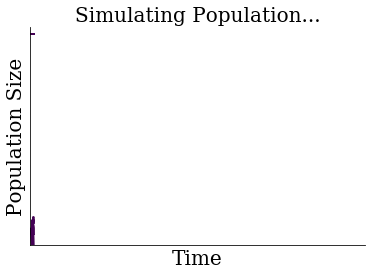

In [13]:
%timeit framer(tot_frames)

In [12]:
tot_frames*2/60

5.0

HBox(children=(IntProgress(value=0, description='Looping through all strains: ', max=10047), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Plotting Lineages: ', max=10047), HTML(value='')))

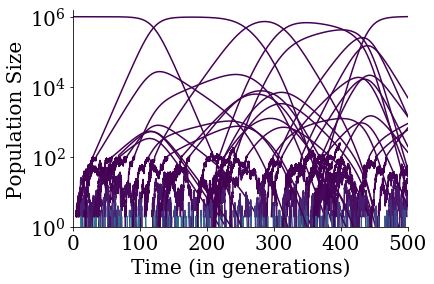

In [10]:
# plot results
strainlist = []
for bact in tqdm(sim.allStrains, desc='Looping through all strains'):
    try:
        strainlist.append((max(bact.poptrace), bact))
    except:
        strainlist.append((0, bact))
sortedlist = sorted(strainlist, key=lambda x: x[0])
endlist = [(i, bact) for i, (__, bact) in enumerate(reversed(sortedlist))]
shuffle(endlist)

n_strain = len(sortedlist)
colors = pl.cm.viridis(np.linspace(0,1, n_strain))
ind = 0
for i, bact in tqdm((endlist), desc='Plotting Lineages'):
    if (i < 30) :
        t = bact.timepoints
        pop = bact.poptrace
        plt.semilogy(t, pop, color=colors[i])
    elif (i % 20 == 0):
        t = bact.timepoints
        pop = bact.poptrace
        plt.semilogy(t, pop, color=colors[i-n_big])
            
plt.xlabel('Time (in generations)')
plt.ylabel('Population Size')
# plt.title('Standard Code: Population Traces for Established Strains')
plt.xlim([T_curr, T_sim])
plt.ylim([1e0, 10**(6.2)])
sns.despine()
plt.show()